# #ARE_YOU_FOLLOWING_OBAMA?

## 1. Introduction

There are a lot of celebrities using Twitter, who are followed by tens of millions of general users. Whether a specific user will follow a particular celebrity is an interesting question to ask.

In this project, the team aims at answering the question of whether a looks into predicting whether a given user is following Barack Obama (@BarackObama). Two different learning models are tried: Collaborative Filtering and Bag-of-words model. Collaborative Filtering did not work quite well in our case, but after switching gear, bag-of-words seems to work much better.


## 2. Twitter API and Tweepy

In this project we mainly used tweepy as a wrapper of the Twitter API. Most queries we made were for user followers, friends, and tweets.

In [ ]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from twython import Twython


consumer_key = '<CONSUMER_KEY>'
consumer_secret = '<CONSUMER_SECRET>'
access_token = '<ACCESS_TOKEN>'
access_secret = '<ACCESS_SECRET>'
auth = OAuthHandler(consumer_key=consumer_key, consumer_secret=consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth) 

## 3. Collaborative Filtering

**This part was done before our midreport therefore not only predicting whether a user will follow Obama, but also whether he or she is likely to follow any Twitter celebrities**

The team found that the behavior of a user following another user is in some way similar to how movie ratings happen for MovieLens dataset. The difference is that, instead of a floating number from 1 to 5 for a rating, the unidirectional relationship of follow/not follow only has a binary value. It would be interesting to observe how this property would affect the performance of alternating least squares method when it’s applied. And as a possible way to close the gap between the two scenarios, a “fondness” score could be added for a follower to one of the target he or she is following, indicating how much of a fan the follower is to the target. For example, if a user has retweeted or liked a lot of posts of the target, the fondness score might then be relatively high.

### 3.1 Collecting Data

First,the team chose 100 popular twitter accounts based on Twitter statistics and used BeautifulSoup to get a list these 100 accounts’ screen_names.

In [ ]:
import urllib2
from bs4 import BeautifulSoup

web = "http://twittercounter.com/pages/100?vt=1&utm_expid=102679131-111.l9w6V73qSUykZciySuTZuA.1&utm_referrer=https%3A%2F%2Fwww.google.com%2F"

page = urllib2.urlopen(web)
soup = BeautifulSoup(page)
span_list = soup.find_all("span", {"itemprop":"alternateName"})
# list of screen name of top 100 Twitter celebrity
celebrities = [] 
for each in span_list:
    celebrities.append(str(each.text)[1:])

Next, we hope to get 1 follower from each celebrity's follower group, by simply selecting the most recent follower.

In [ ]:
def retrieve_n_recent_follower_ids(id, n):
    """ Retrieve the most recent n followers from a given Twitter id or screen name. """
    
    followers = []
    for i, follower_list in enumerate(tweepy.Cursor(api.followers_ids, id).pages()):
        if len(followers) >= n:
            break
        followers.append(follower_list)
    return followers


def generate_user_id_list (id_list,n):
    """ Generate the entire set of users that unions the returned list of running the retrieve_n_follower_ids 
    for each celebrity account"""
    
    users = []
    for id in id_list:
        try:
            new_users = retrieve_n_follower_ids(id, n)
        except tweepy.TweepError:
            time.sleep(60*15)
            new_users = retrieve_n_follower_ids(id, n)
        users += new_users
        
    return set(users)


In [ ]:
users = generate_user_id_list (celebrities, 1)


### 3.2 Generate User-celebrity matrix

Now that both user and celebrity arrays are ready, the following step is to generate the m by n matrix (m is number of total general users and n the number of celebrities collected). matrix[i][j] indicates whether user i is currently following celebrity j. 

In [ ]:
import numpy as np
def genenerate_user_celebrity_matrix(users, celebrities): # both are lists of Twitter IDs
    matrix = np.zeros((len(users), len(celebrities)))
    celebrity_set = set(celebrities)
    for i in range(len(users)):
        try:
            friends = get_friends(users[i]) 
        except tweepy.TweepError:
            time.sleep(60*15)
            friends = get_friends(users[i])    
        for j in range(len(celebrities)):
            matrix[i][j] = celebrities[j] in friends
    return matrix

In [ ]:
matrix = genenerate_user_celebrity_matrix(users, celebrities)

### 3.3 Training and Predicting

In [ ]:
import math
def process(following, P):
    """ Given a dataframe of following and a random permutation, split the data into a training 
        and a testing set, in matrix form. 
        
        Args: 
            following (2D numpy array) : a 2D numpy array of following 
            P (numpy 1D array) : random permutation vector
            
        Returns: 
            (X_tr, X_te)  : training and testing splits of the following matrix (both 
                                         numpy 2D arrays) 
    """
    l= len(following)   
    train_length = int(math.floor(l*0.9))
    train_P = P[0:train_length]
    test_P = P[train_length:]
    
    new_p1 = np.zeros(following.shape[1])
    new_p2= np.zeros(following.shape[1])
    for each in train_P:
        new_p1[each] = 1
    for each in test_P:
        new_p2[each] = 1
    #training matrix
    training_list = []
    for i,xi in enumerate(following):
        x = (xi*new_p1).tolist()
        training_list.append(x)
    
    
    #testing matrix
    testing_list = []
    for i,xi in enumerate(following):
        x = (xi*new_p2).tolist()
        test_list.append(x)
        
    return np.array(training_list),np.array(testing_list)
    pass


X_tr, X_te = process(new_matrix, np.random.permutation(new_matrix.shape[1]))

In [ ]:
def error(X, U, V):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each movie
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    dif =np.square(X- U.dot(V.T)) 
    new_dif =[X!=0]*dif
    return np.mean(new_dif)
    pass

def train(X, X_te, k, U, V, niters=51, lam=10, verbose=False):
    """ Train a collaborative filtering model. 
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            X_te (numpy 2D array) : the testing ratings matrix as specified above
            k (int) : the number of features use in the CF model
            U (numpy 2D array) : an initial matrix of features for each user
            V (numpy 2D array) : an initial matrix of features for each movie
            niters (int) : number of iterations to run
            lam (float) : regularization parameter
            verbose (boolean) : verbosity flag for printing useful messages
            
        Returns:
            (U,V) : A pair of the resulting learned matrix factorization
    """
    temp = X !=0
    W = temp.astype(np.int)
    for ite in range(niters):
        for j,w in enumerate(W): 
            U[j]=np.linalg.solve(V.T.dot((V.T.dot(np.diag(w))).T) + lam * np.eye(k), V.T.dot(X[j]))
        for j,wt in enumerate(W.T):
            V[j] = np.linalg.solve(U.T.dot(np.diag(wt).dot(U))+lam *np.eye(k),U.T.dot(X[:,j]))
        if verbose == True:
            if ite== 0:
                print "Iter |Train Err |Test Err"
            train_error= error(X, U, V)
            test_error = error(X_te, U, V)
            print ite, "|",train_error,"|",test_error
            
    return U,V
    pass

In [ ]:
U = np.random.rand(X_tr.shape[0],10)
V = np.random.rand(X_tr.shape[1],10)
U,V = train(X_tr, X_te, 10, U, V, niters=10, lam=3, verbose=True)

The team got the following output: 
```python

Iter |Train Err |Test Err
0 | 0.0215557892728 | 0.0247727272727
1 | 0.0124878550122 | 0.0247727272727
2 | 0.011533655087 | 0.0247727272727
3 | 0.0113421192911 | 0.0247727272727
4 | 0.0112910212752 | 0.0247727272727
5 | 0.011275019604 | 0.0247727272727
6 | 0.0112696053164 | 0.0247727272727
7 | 0.0112677039911 | 0.0247727272727
8 | 0.0112670189888 | 0.0247727272727
9 | 0.0112667645063 | 0.0247727272727
```

### 3.4 Observations and Analysis

As we can see from the result, the training errors decrease as the algorithm iterates, and is always smaller than the testing error. However, the testing error doesn’t seem to change at all, which might imply that our training data is not enough, or that using CF to extract hidden features might not be such a great idea.
We think the failure is because of two reasons: 
1. In our case, matrix [i][j] means ith user does not follow jth celebrity, instead of meaning missing data. 
2. Our matrix’s nonzero entry’s values are always 1, instead of a floating number, therefore it is hard to learn from the data that how ith user favors jth celebrity. As a result, it is difficult to use collaborative filtering algorithm to generate useful “hidden” feature matrixes U and V.

## 4. Bag-of-words model

We found that user tweets contain a lot of information and might be used to predict whether a user is following Obama. For example, when a user's tweets convey his or her interest in the field of politics, it would be reasonable to say that the user is more likely to have followed Obama. With this assumption in mind, we decided to use the bag-of-words model. Training data would be collective tweets from followers and non-followers of Obama respectively, and each testing instance would just be collective tweets from a specific user.

### 4.1 Collecting data

Due to the rate limits on Twitter API calls, we spent quite some time collecting the amount of data that we thought we needed for the project. 

For postive examples (tweets from users who follow Obama), we simply collected the most recent 2000 followers of Obama. However, we found that many of the users have very few tweets, which might imply that they are fairly new Twitter users (also considering the fact that they just started following Obama). In order to keep the randomness in our selection of users rather than having a bias towards new users, we only collected tweets from those users who have more than 50 tweets. We collected 200 tweets from each "qualified" user, or however tweets that user has, if the count is less than 200.

In [ ]:
# Get most recent 2000 followers of Obama
followers = api.followers_ids("BarackObama")[:2000]

In [ ]:
import os.path
def get_tweets(screen_name, subdirectory):
    """ Retrieve and save 200 tweets (or all tweets if less than 200) from the user given screen name, 
    if and only if the user has more than 50 total tweets"""
    
    try:
        os.mkdir(subdirectory)
    except Exception:
        pass
    try: 
        new_tweets = api.user_timeline(screen_name = screen_name,count=200)
        if len(new_tweets)>50:
            outtweets = [tweet.text.encode("utf-8") for tweet in new_tweets]
            tweets_200 = ' '.join(outtweets)
            with open(os.path.join(subdirectory, '%s_tweets.txt' % screen_name), 'a') as f:
                f.write(tweets_200)
            return True
        else:
            return False
    except tweepy.TweepError:
        pass
    pass

In [ ]:
# a list of Boolean values, indicating whether the user has more than 50 tweets therefore whose tweets are saved
tweet_saved = [] 

for follower in followers:
    screen_name = api.get_user(follower).screen_name
    tweet_saved.append(get_tweets(follower, "obama_followers_tweets"))

print len(tweet_saved == True) # print count of valid followers

In order to find users who do not follow Obama, we inspected the followers of the previous group of 2000 users who follow Obama. We think this is a good way to maintain the randomness in our training and test data. Specifically, we select the most recent follower of each obama-follower, check whether a) he or she is following Obama b) he or she has more than 50 tweets. Only when both a) and b) are met do we save the tweets from the specific user. Twitter does not have any endpoints for checking the existence of friendship between two users, therefore we retrieved the entire friend list of any user and checked whether Obama is in the list.

In [ ]:
# Get one follower from each of the previous 2000 followers of Obama
candidates = [retrieve_n_recent_follower_ids(follower, 1) for follower in followers]

print len(candidates) # should print 2000
print candidates[:20] # print some IDs

In [ ]:
def isFollowing(users, target_user):
    """Given the twitter ID of a list of users and a target user screen name, return a list of Boolean values. 
    The value at specific index of returned vector corresponds to the fact of whether the user at the same index 
    follows the target user. """
    
    isFollowing = []
    for user in users:
        try:
            following = api.friends_ids(user)
            if target_user in following:
                isFollowing.append(1)
            else:
                isFollowing.append(0)
        except tweepy.TweepError:
            print "sleep"
            time.sleep(60*15)
            print "wakeup"
            following = api.friends_ids(user)
            if target_user in following:
                isFollowing.append(1)
            else:
                isFollowing.append(0)
    return isFollowing

In [ ]:
# a list of Boolean values, indicating whether the candidate is following Obama
is_obama_follower = isFollowing(candidates, obama_id)
print len(is_obama_follower == 0) # number of non-followers (not necessarily with >50 tweets)


In [ ]:
# get tweets from the non-followers
tweet_saved = []
for i, candidate in enumerate(candidates):
    screen_name = api.get_user(candidate).screen_name
    if (is_obama_follower[i] == 0):
        tweet_saved.append(get_tweets(screen_name, "obama_non_followers_tweets"))
        
print len(tweet_saved == 1) # should print count of valid non-followers

### 4.2 Processing tweet data

We discovered that, the raw tweets we got from both follower and non-follower groups might contain contents that we need to take care of before the tweets could be used for "bag-of-words" model, including non-English words, punctuations, emoticons, hash-tags, etc. To be more specific, our preprocess procedure includes:

1. remove stop words, including some customized stopwords
2. remove punctuations
3. remove non ascii characters
4. remove tweets that are not written in English
5. remove non words, such as "ab123"
6. remove words with length equals 1

In [2]:
import rake
import operator
import stop_words
import gensim
import glob
import enchant
import random
import collections
from guess_language import guessLanguage
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words

def remove_non_ascii(text):
    return ''.join([i if ord(i) < 128 else '' for i in text])

tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en') # create English stop words list
d = enchant.Dict("en_US")
input_files = glob.glob('obama_non_followers_tweets/*.txt')
custom_stop_words = ["just", "like", "can", "video", "new", "love", "via", "will", "one", "now",
                     "know", "see", "get", "don", "today", "people", "day", "time", "make"]


def process_all(fnames, label):
    for cnt, fname in enumerate(fnames):
        sample_file = open(fname, 'r')
        text = sample_file.read()

        # tokenize
        raw = text.lower()
        tokens = tokenizer.tokenize(raw)

        # remove non ascii str
        tokens = map(remove_non_ascii, tokens)
        tokens = filter(bool, tokens)
        tokens = filter(lambda x: len(x) > 2, tokens)

        # remove stop words
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stopped_tokens = [i for i in stopped_tokens if not i in custom_stop_words]

        texts = [i for i in stopped_tokens]
        processed_texts = str(' '.join(texts))

        if str(guessLanguage(processed_texts)) != 'en':
            continue

        # remove non english words
        processed_texts_en = []
        for tok in processed_texts.split():
            if d.check(tok):
                processed_texts_en.append(tok)
        processed_texts_en = ' '.join(processed_texts_en)

        if len(processed_texts_en.split()) < 100:
            continue
        tag = label
        content = str(cnt) + '\t' + tag + '\t' + processed_texts_en + '\n'
        
        filename = "OBAMA_" + label + ".txt"
        with open(filename, "a") as myfile:
            myfile.write(content)

        if cnt % 100 == 0:
            print str(cnt) + " round completed...."


            
input_files = glob.glob('obama_non_followers_tweets/*.txt')
process_all(input_files, 'FALSE')
input_files = glob.glob('obama_followers_tweets/*.txt')
process_all(input_files, 'TRUE')

### 4.3 Learning and predicting

We merged the preprocessed tweets into two big corpus, the follower tweets and the non-follower tweets. We used Naive Bayes and Maxiumn a Posteriori Probability (MAP) for the classifier, where we calculated the frequency for each word in both corpus, with Laplace smoothing. During the testing phase, when given the collective tweets of a user, we calculate the probability of following and not following, and classify the user based on the one more likely. 

**Because part of the code we used for this section is from one of the team member's homework for another class, we will not post the code here, but submit it through Autolab instead. **


We carefully selected training and test set such that both set have about the same size. We varied the size of training and test dataset to see how the model perform on different sizes. For each different size, we ran the model three times with randomly selected training and test set from our pool, and the results are as follows:

```
collective tweets from obama-followers train|test|#collective tweets from non-obama-followers train|test 
--> (run_1_result, run_2_result, run_3_result) 

253 50 295 50 --> (0.77, 0.84, 0.77)
200 50 250 50 --> (0.74, 0.72, 0.74)
150 50 200 50 --> (0.72, 0.72, 0.70)
100 50 150 50 --> (0.72, 0.67, 0.71)
50 50 100 50 --> (0.77, 0.74, 0.71)
50 50 50 50 --> (0.56, 0.63, 0.67)
25 50 25 50 --> (0.68, 0.57, 0.67)
10 50 10 50 --> (0.58, 0.61, 0.61)
```

As we could see, the average prediction accuracy increased as we used more training data. 



In [ ]:
import matplotlib.pyplot as plt


figIter = plt.figure()
axIter = figIter.add_subplot(1, 1, 1)

num_train = [100, 150, 250, 350, 450, 550]
accuracy = [0.62, 0.716, 0.716, 0.72, 0.736, 0.78]

axIter.plot(num_train, accuracy, marker="o")

# axIter.legend(loc=2)

axIter.set_xlabel("#training instances")
axIter.set_ylabel("accuracy")
axIter.grid(True)

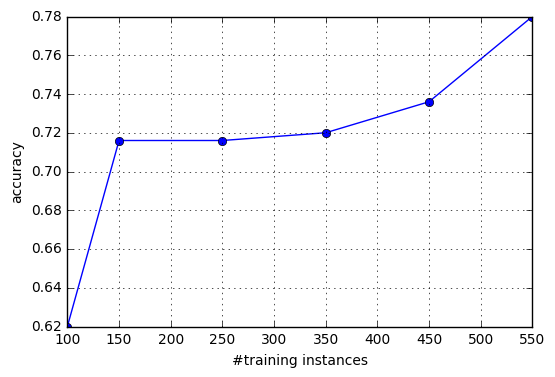

In [3]:
plt.show()

### 4.4 Observations and Analysis

We had some interesting observations after further analyzing both the result and the data. We also tried to modify our model in a couple of ways to see whether its performance would improve. 

a ) We started with the default nltk stop word set, but later when we inspected the most frequent words from the two corpus, we found that there were still a lot of overlapping between the two lists of top words, which did not necessarily seem relevant to whether the user would actually follow Barack Obama. Since the idea for "bag-of-words" text classification was that the corpus under each class label should have rather "characteristic" words, meaning that they should be specific to that label, we decided to add those words to the stop word set. 


Some of the results of comparing the model with and without customized stop words:
```
200 50 250 50 
--> (0.74, 0.72, 0.74) with customized stopwords
--> (0.61, 0.51, 0.61) without customized stopwords

253 50 295 50 
--> (0.77, 0.84, 0.77) with customized stopwords 
--> (0.62, 0.52, 0.61) without customized stopwords
```


b) The accuracy seems to have something to do with the training set we chose to use. When using a different subset of all training data we got as the training set while keeping the test set the same, the results might vary a bit (by around 10%). We suspected that this was caused by the fact that a user's tweets sometimes might not accurately reflect the friendship status between the user and Obama. To use a more straightforward example, if a user does not talk about politics on Twitter, that does not necessarily suggest that the user would not follow Obama, and vice versa. In those cases, the tweets can only get the model more confused by adding irrelevant words to the corpus, while not actually helping the prediction. When the subset contains tweets that have stronger relevance to the classification (say, when contains a lot of keywords from the field of politics), the model may tend to perform better on test data.


We realized that we could've possibly chosen another Twitter celebrity for this project such that the model would probably have better performance. If we had used Katy Perry, for instance, it's reasonable to believe that Twitter followers of Katy Perry will probably tweet more about music comparing to Twitter followers of Obama tweet about politics.

Some other features we think might be helpful, if we had more time to work on this model, would be 
1. How many of my followers have followed Obama, and
2. How many of my friends(people I'm following) are "similar" to Obama (maybe are also politicians in this case)


## 5. Application

While we chose to explore this very topic out of curiosity and interest, we believe that it has some quite interesting and useful applications beyond the scope of our project. The question that we are trying to answer, whether a general user is following Barack Obama or not given his or her tweets, could be expanded to one of the following:
1. Whether a general user is following (or is likely to follow) any celebrity
2. Whether a general user is follwing (or is likely to follow) any other general user

If we are able to predict the above, the results could then be used to generate recommendations that a user will be likely to follow.

## 6. Conclusion

In this project we tried to answer the question of whether a general user is following Barack Obama or not given his or her tweets. We used Collaborative Filtering and Bag-of-words model as two very different approaches.

Collaborative Filtering did not give very positive results due to the potential lack of outstanding features from those users, and the fact that all values are binary (follow/not follow) instead of a more flexible floating number. Bag-of-words model, on the other hand, seems more promising as we took advantage of the tweets which should be able to imply the user's general interest to some extent, thus whether they are more likely to have followed a political figure, Barack Obama.